This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por) but the focus of this analysis will be the math data. In this notebook we will be predicting the G3 grade based on different features. Data link https://archive.ics.uci.edu/ml/datasets/Student+Performance

**Importing the necessary python libraries**

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score



Mounting our data on the google drive to avoid re uploading it anytime runtime is disconnected 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# since our data is separated using semicolons we use sep=;
data = pd.read_csv("/content/drive/MyDrive/TM_assignment/student-mat.csv", sep=";")
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


# **Data Preprocessing**

Insepcting the dataset


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

checking for missing data

In [5]:
data_missing_df = pd.DataFrame(data.isnull().sum(),columns=['no_missing values'])

In [6]:
# we do not have any missing data
data_missing_df.reset_index()

,index,no_missing values
0,school,0
1,sex,0
2,age,0
3,address,0
4,famsize,0
5,Pstatus,0
6,Medu,0
7,Fedu,0
8,Mjob,0
9,Fjob,0


In [7]:
# standerdizing the columns names so that they make sense
data.rename(columns = {"Medu":"Mother's education","Fedu":"Father's education",'famsize	':"Family size",'Mjob':"Mother's job",'Fjob':"Father's job"}, inplace = True)
data.head()

,school,sex,age,address,famsize,Pstatus,Mother's education,Father's education,Mother's job,Father's job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


# **Exploratory data analysis**

Finding out the number of guardians in the three categories 

In [8]:
# checking the number of most guardians
m_guardian = data["guardian"].value_counts()
m_guardian

mother    273
father     90
other      32
Name: guardian, dtype: int64

checking the number of absentees based on the age 

In [9]:
# check the the absentees based on age
a_absentees = data.groupby(["age"])['absences'].sum()
a_absentees

age
15    274
16    567
17    633
18    496
19    251
20     15
21      3
22     16
Name: absences, dtype: int64

# **Feature engineering**

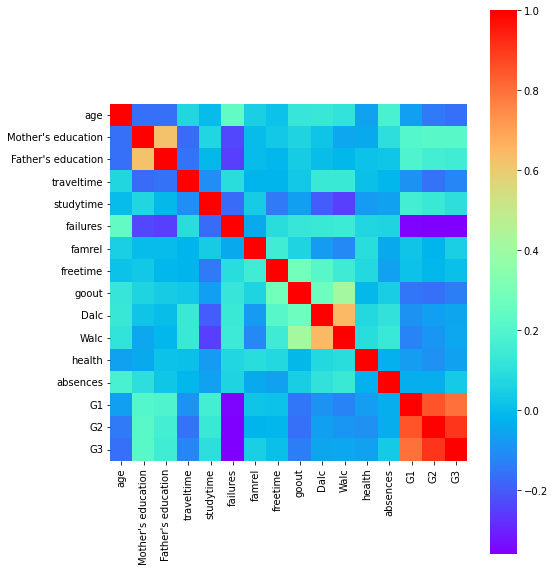

In [10]:
# checking corrrelation of the variables
corr = data.corr()
plt.figure(figsize=(8, 10))
sns.heatmap(corr, square=True, annot=False, cmap='rainbow')

Text(0, 0.5, 'Columns')

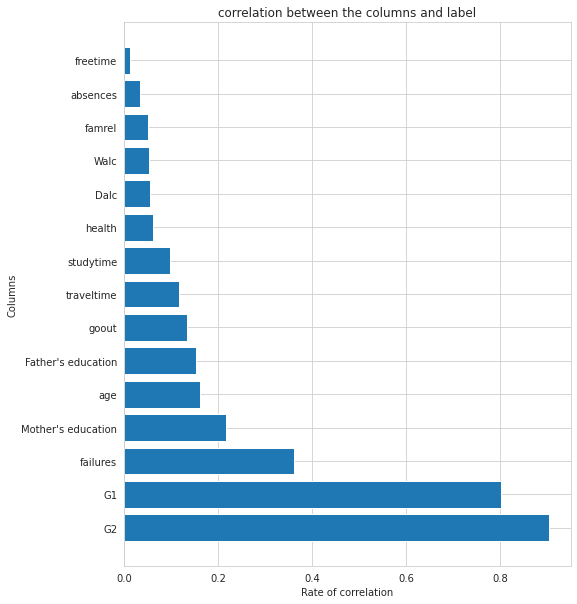

In [11]:
#checking how columns correlate with the label
labelCorr = abs(corr['G3']).sort_values(ascending=False).drop(['G3'], axis=0)
sns.set_style("whitegrid")
plt.figure(figsize=(8, 10))
plt.title("correlation between the columns and label")
plt.barh(labelCorr.index, labelCorr)
plt.xlabel("Rate of correlation")
plt.ylabel("Columns")

Conclusion
Checking for correlation to check for the strength of relationship between the label(G3) and the features

In [12]:
# dropping the unecessary columns and selecting the ones that are useful
# reason we did trimming rather than dropping is because we have very many useless columns compared to useful ones
data = data[['G2','G1','G3','failures',"Mother's education",'age']]


# **Building and Evaluating the models**

In [13]:
# # Scaling our data
X = pd.DataFrame(data.drop(['G3'],axis=1))
Y = pd.DataFrame(data['G3'])

In [14]:
# splitting our data to test and train sets for the model
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [15]:
x_train.head()

,G2,G1,failures,Mother's education,age
181,13,12,0,3,16
194,14,13,0,2,16
173,7,8,3,1,16
63,9,10,0,4,16
253,9,8,0,2,16


In [16]:
# using linear regression
linear = LinearRegression()
linear.fit(x_train, y_train)

LinearRegression()

In [17]:
pred_y = linear.predict(x_test)
print("The first five prediction {}".format(pred_y[:5]))
print("The real first five labels {}".format(y_test[:5]))

The first five prediction [[ 6.24608394]
 [12.02423368]
 [ 3.22337152]
 [ 8.47692257]
 [ 7.36027182]]
The real first five labels      G3
78   10
371  12
248   5
55   10
390   9


We are evaluating the model based on mean squared error which is able to tell us amount of error in our model by checking the average squared difference between the actual and predicted values

In [18]:
mse = metrics.mean_squared_error(y_test, pred_y)
print("Mean Squared Error {}".format(mse))

Mean Squared Error 4.538735351550336


In [19]:
# train our model and check for accuracy
linear.fit(x_train, y_train)
accuracy = linear.score(x_test,y_test)
print(accuracy)

0.7786527730360888


These are the constants used to develop the line of best fit.The coefficient each slope value and the intercept shows the point where the line crosses the y axis 

In [20]:
print('Coefficient: \n', linear.coef_)
print('Intercept: \n', linear.intercept_)

Coefficient: 
 [[ 0.96770861  0.15467515 -0.37811942  0.02632211 -0.12877177]]
Intercept: 
 [0.53784787]
